In [2]:
import os


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"] = "-1";

import cv2, re, sys
import math, time, datetime
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tabulate import tabulate
from util import profile, keras_model_memory_usage, memory_usage, model_profile
from callbacks import WarmUpCosineDecayScheduler
from losses import FocalLoss, SEG_Loss, INST_Loss
from metrics import dice_coef, mean_iou, binary_iou, Class_Wise_IOU, strict_iou
from data_gen import Tumor_Data_Generator, make_data_list, Tumor_IO, numericalSort
from morphology import bwmorph_thin, gray2encoded, seprate_instances
from pallet_n_classnames import pannuke_classes, pallet_pannuke
from models import num_of_classes, efficent_pet_203_clf
'''
# Set the backend float after you call keras modules if called before keras modules will be called in their default config
keras.backend.floatx()
keras.backend.set_floatx('float16')
'''
import tensorflow as tf
from tensorflow import keras
tf_version = tf.__version__
if int(str(tf.__version__)[0]) == 1:
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    #config.log_device_placement = True  
    sess = tf.Session(config=config)
elif tf_version == '2.0.0':
    tf.compat.v1.disable_eager_execution()
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    # for gpus in physical_devices:
    #   tf.config.experimental.set_memory_growth(gpus, True)
      
elif int(str(tf.__version__)[0]) == 2:
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    # for gpus in physical_devices:
    #   tf.config.experimental.set_memory_growth(gpus, True)
    
if int(str(tf.__version__)[0]) == 2:
#    import tensorflow_addons as tfa
    from tensorflow.keras.layers import Input
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, LearningRateScheduler, Callback, TensorBoard
    from tensorflow.keras.optimizers import Adam, Nadam, SGD
    from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.utils import plot_model, multi_gpu_model
    from tensorflow.keras.regularizers import l2, l1
    from tensorflow.keras.layers import Conv2D, SeparableConv2D, DepthwiseConv2D, Dense

    print('\n Imorted libraries for tf.version = 2.x.x \n')
    
if int(str(tf.__version__)[0]) == 1:
    from keras.layers import Input
    from keras.models import Sequential
    from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, LearningRateScheduler, Callback
    from keras.optimizers import Adam, Nadam, SGD
    from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
    from keras.utils import plot_model, multi_gpu_model
    from keras.regularizers import l2, l1
    from keras.layers.convolutional import Conv2D, SeparableConv2D, DepthwiseConv2D
    from keras.layers import Dense
    print('\n Imorted libraries for tf.version = 1.x.x \n')


 Imorted libraries for tf.version = 2.x.x 



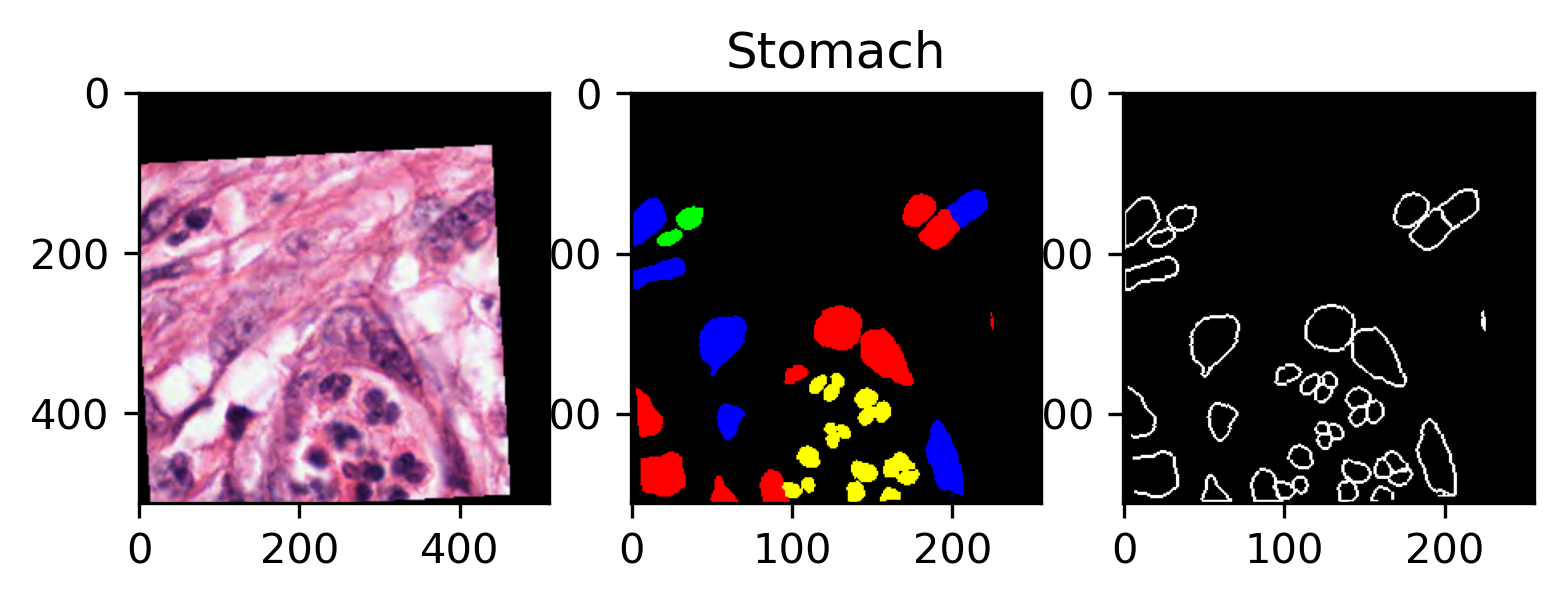

In [3]:
num_class = num_of_classes()
weight_name = 'residual_component'
log_name = datetime.datetime.now().strftime("%Y%m%d-%H%M") + weight_name
Batch_size = 16
BiFPN_ch = 160
Epoch = 150
warmup_epoch = 3
im_width = 512
im_height = 512
d = 1 # GT mask downsampler
input_ch = 6
seed = 1
initial_lr = 0.16#0.005#0.0005
cycle = 100
mul_factor = 1.5
lr_decay = 0.9
drop_epoch = 5
power = 0.9
init_dropout = 0.2
Enc_Dropout_Type = 'SD'     #  'VD' -or- 'SD" -or- 'DB'
Dec_Dropout_Type = 'DB'     #  'VD' -or- 'SD" -or- 'DB'
'''
fliping dropout in enc and dec reduce accuracy
'''
dropout_schedule = np.array([init_dropout, 0.1, 0.15, 0.2, 0.3]) #@Epoch 0 10 20 30
dropout_after_epoch = np.array([0, 7, 14, 21, 30])
Blocksize = 5
use_mydropout = use_customdropout()
Weight_Decay = True 
w_decay_value = 0.0005
lr_schedule = 'SGDR_warmup'  # polynomial_decay  -or- step_decay -or- K_decay -or - SGDR_lr -or- SGDR_warmup
LOSS_function = '{Focal, Seg, Inst}'    # Weighted_BCEnDice_loss, focal_CE, HED_loss, triplet_loss
output_ch = num_class
class_names = ['Background', 'Inflammatory', 'Connective',
              'Dead ', 'Epithelial', 'Neoplastic ']
######################################################
#    Start Data Gen
######################################################
# train_dir = '/home/user01/data_ssd/Talha/pannuke/k_fold/k_fold_23/train/'
# val_dir = '/home/user01/data_ssd/Talha/pannuke/k_fold/k_fold_23/test/'
# test_dir = '/home/user01/data_ssd/Talha/pannuke/k_fold/k_fold_23/test/'

train_dir = '/home/user01/data_ssd/Talha/pannuke/train/'
val_dir = '/home/user01/data_ssd/Talha/pannuke/val/'
test_dir = '/home/user01/data_ssd/Talha/pannuke/test/'

train_imgs_paths, train_sem_masks_paths,  train_inst_masks_paths= make_data_list(train_dir)
val_imgs_paths, val_sem_masks_paths, val_inst_masks_paths = make_data_list(val_dir)
test_imgs_paths, test_sem_masks_paths, test_inst_masks_paths = make_data_list(test_dir)

tumor_types = np.unique(np.load('/home/user01/data_ssd/Talha/pannuke//types.npy'))# give the list of tumour types

train_data_gen = Tumor_Data_Generator(train_imgs_paths, train_sem_masks_paths, train_inst_masks_paths, tumor_types, Batch_size,
                                      im_width, im_height, data_augment=True, shuffle=True)
val_data_gen = Tumor_Data_Generator(val_imgs_paths, val_sem_masks_paths, val_inst_masks_paths, tumor_types, Batch_size,
                                      im_width, im_height, data_augment=False, shuffle=True)
test_data_gen = Tumor_Data_Generator(test_imgs_paths, test_sem_masks_paths, test_inst_masks_paths, tumor_types, Batch_size,
                                      im_width, im_height, data_augment=False, shuffle=True)

# to shuffle data at start of training
train_data_gen.on_epoch_end()
test_data_gen.on_epoch_end()
val_data_gen.on_epoch_end()


num_images = len(train_imgs_paths)
num_images_val = len(val_imgs_paths)
num_images_test = len(test_imgs_paths)

######################################################
# code sanity check
######################################################
z_image_hr, z_label_seg_clf = train_data_gen.__getitem__(28)
j = 0 
z_label_clf = z_label_seg_clf[0]
z_label_seg = z_label_seg_clf[1]
z_label_inst = z_label_seg_clf[2]
fig, ax = plt.subplots(1, 3)
ax[0].imshow(z_image_hr[j,:,:,:3])
ax[1].imshow(tf_gray2rgb(z_label_seg[j,:,:, 0], pallet_pannuke))
ax[1].set_title(tumor_types[np.argmax(z_label_clf[0,:])])
ax[2].imshow(z_label_inst[j,:,:,0], cmap='gray')
batchX = str((z_image_hr[0].shape))
batchY = str((z_label_inst.shape, z_label_seg.shape))

# import imgviz

# tile = imgviz.tile(imgs=[z_image_hr[0,:,:,3],
# z_image_hr[0,:,:,4],
# z_image_hr[0,:,:,5]])
# plt.imshow(tile)

In [4]:
input_img = Input((im_height, im_width, input_ch), name='ip')

model = efficent_pet_203_clf(input_img, output_ch, bifpn_ch = BiFPN_ch, dropout_rate=init_dropout, use_dropout=True)

model.compile(optimizer=SGD(momentum=0.9), loss={'clf_out': FocalLoss,
                                                    'seg_out': SEG_Loss,   
                                                    'inst_out': INST_Loss}, 
                                            metrics={'clf_out':'accuracy',
                                                    'seg_out': mean_iou,
                                                    'inst_out': mean_iou}) 

# # print model summary on txt file
#model.summary()
orig_stdout = sys.stdout
f = open('/home/user01/data_ssd/Talha/pannuke/pan_final/efficent_pet_203.txt', 'w')
sys.stdout = f
print(model.summary())
sys.stdout = orig_stdout
f.close()
lr_scheduleW = lr_schedule 
trainable_param = model.count_params()
print('No. of parameters = ~',trainable_param/1000000,'Million')
table =  model_profile(model, Batch_size, initial_lr, w_decay_value, init_dropout, 
                  lr_scheduleW, Weight_Decay, use_mydropout, dropout_schedule, 
                  dropout_after_epoch, LOSS_function, batchX, batchY, 
                  Enc_Dropout_Type, Dec_Dropout_Type , Blocksize)


# Custom Callbacks
plot_losses = PlotLearning(table) 
#show_pred = PredictionCallback(path_train, im_height, im_width)
DO_schedule = CustomDropoutScheduler(dropout_schedule, dropout_after_epoch)
KR_schedule = CustomKernelRegularizer()
if lr_schedule == 'SGDR_lr' :
    LR_schedule = SGDRScheduler(min_lr=1e-7,max_lr=initial_lr,steps_per_epoch=num_images/Batch_size,
                                lr_decay=lr_decay,cycle_length=cycle,mult_factor=mul_factor)
elif lr_schedule == 'SGDR_warmup':
    LR_schedule = WarmUpCosineDecayScheduler(learning_rate_base=initial_lr,
                                             total_steps=int(Epoch * num_images/Batch_size),
                                             warmup_learning_rate=0.0,
                                             warmup_steps=int(warmup_epoch * num_images/Batch_size))
else:
    LR_schedule = CustomLearningRateScheduler(lr_schedule, initial_lr, lr_decay, Epoch, drop_epoch, power)
log_tb = TensorBoard(
    log_dir='/home/user01/data_ssd/Talha/pannuke/pan_final/logs_r/{}/'.format(log_name))

print(table)

callbacks = [LR_schedule, log_tb, #plot_losses,
            ModelCheckpoint('/home/user01/data_ssd/Talha/pannuke/pan_final/weights_r/{}.h5'.format(weight_name), verbose=1, save_best_only=True, save_weights_only=True), # Save weights if val loss is improved
            CSVLogger('/home/user01/data_ssd/Talha/pannuke/pan_final/logs_r/{}.csv'.format(log_name), separator=',', append=True)
            ]  

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [4]:
# results = model.fit(train_data_gen, steps_per_epoch= num_images/Batch_size, validation_data=val_data_gen, epochs=Epoch, 
#                               initial_epoch = 0, validation_steps= num_images_val/Batch_size, callbacks=callbacks, verbose=1)


In [5]:
model.load_weights('/home/user01/data_ssd/Talha/pannuke/pan_final/weights_r/{}.h5'.format(weight_name))
print(weight_name)

residual_component


In [10]:
# model.save('/home/user01/data_ssd/Talha/pannuke/pan_final/tsfd_net.h5')

In [7]:
metrics = model.evaluate(test_data_gen)
result = np.concatenate((np.asarray(model.metrics_names).reshape(-1,1), np.round(np.asarray(metrics).reshape(-1,1),4)), 1)
print(tabulate(np.ndarray.tolist(result), headers = ["Metric", "Value"], tablefmt="github"))
x = np.asarray(metrics).reshape(-1,1)

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
121/121 [==============================] - 36s 295ms/step - loss: -0.0454 - clf_out_loss: 4.0553e-04 - seg_out_loss: 0.0666 - inst_out_loss: -0.1157 - clf_out_accuracy: 0.9750 - seg_out_mean_iou: 0.8012 - inst_out_mean_iou: 0.4227
| Metric            |   Value |
|-------------------|---------|
| loss              | -0.0454 |
| clf_out_loss      |  0.0004 |
| seg_out_loss      |  0.0666 |
| inst_out_loss     | -0.1157 |
| clf_out_accuracy  |  0.975  |
| seg_out_mean_iou  |  0.8012 |
| inst_out_mean_iou |  0.4227 |


In [7]:
from morphology import (bwmorph_thin, gray2encoded, seprate_instances, water, 
                        remove_small_obj_n_holes, assgin_via_majority, decode_predictions)

# _, new = water(img.squeeze(), seg_op)
# plt.imshow(new)
length = len(test_imgs_paths)
thresh = 0.5
# Save predicitons in PanNuke format and save in array (channels 0 and 5 will be swaped by 'seprate_instances')
op = np.zeros((length, 256, 256, 6))
orig = np.zeros((length, 256, 256, 6))
types = []
names = []
for i in trange(length, desc='Making Arrays for running Eval script'):
    # saving predictions
    img_rgb, sem_gt , inst_gt, h = Tumor_IO(test_imgs_paths[i], test_sem_masks_paths[i], test_inst_masks_paths[i], im_width, im_height, False)
    img = np.concatenate((img_rgb, h), axis=-1)
    img = img[np.newaxis, :,:,:]
    # get prediction
    _, seg_op, inst_op = model.predict(img)
    seg_op, inst_op = decode_predictions(seg_op, inst_op, thresh)
    
    op[i, ...] = seprate_instances(seg_op, inst_op, num_classes=6, apply_morph=True, kernel_size=3)
    
    # saving GT in array form
    sem_mask = sem_gt.squeeze()
    inst_mask = inst_gt.squeeze()
    # boundry thining (post processing)
    inst_mask = bwmorph_thin(inst_mask)
    orig[i, ...] = seprate_instances(sem_mask, inst_mask, num_classes=6, apply_morph=True, kernel_size=3)
    
    # saving corresponding tumor types
    for n in range(len(tumor_types)):
        if os.path.basename(test_imgs_paths[i]).find(tumor_types[n]) == -1:
            pass
        else:
            lbl = (tumor_types[n])
        
    types.append(lbl)
    
types = np.asarray(types) 

print('Saving Output Arrays')
np.save('/home/user01/data_ssd/Talha/pannuke/Eval/pred/masks.npy', op) # cnns predictions
np.save('/home/user01/data_ssd/Talha/pannuke/Eval/true/masks.npy', orig) # ground truths
np.save('/home/user01/data_ssd/Talha/pannuke/Eval/true/types.npy', types) # tumor tissue types
print('Done Saving Arrays')

#%%
pred_dir = '/home/user01/data_ssd/Talha/pannuke/Eval/pred/'
gt_dir = '/home/user01/data_ssd/Talha/pannuke/Eval/true/'
save_path = '/home/user01/data_ssd/Talha/pannuke/Eval/metrics/'


!python /home/user01/data_ssd/Talha/pannuke/Eval/metrics/run.py \
    --true_path={gt_dir} \
    --pred_path={pred_dir} \
    --save_path={save_path} \
    --iou_thresh={0.5}

Making Arrays for running Eval script: 100%|██████████| 1923/1923 [12:55<00:00,  2.48it/s]


Saving Output Arrays
Done Saving Arrays
Evaluating: 100%|███████████████████████████| 1923/1923 [01:41<00:00, 19.02it/s]
/home/user01/data_ssd/Talha/pannuke/Eval/metrics/run.py:118: RuntimeWarning: Mean of empty slice
  mPQ_each_image = [np.nanmean(pq) for pq in mPQ_all]
/home/user01/data_ssd/Talha/pannuke/Eval/metrics/run.py:119: RuntimeWarning: Mean of empty slice
  bPQ_each_image = [np.nanmean(pq_bin) for pq_bin in bPQ_all]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Printing calculated metrics on a single split
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
| Nuclei Type    |     PQ |
|----------------|--------|
| Neoplastic     | 0.5746 |
| Inflammatory   | 0.426  |
| Connective     | 0.4314 |
| Dead           | 0      |
| Non-Neoplastic | 0.5704 |
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
| Tissue Type   |    mPQ |    bPQ |
|---------------|--------|--------|
| Adrenal_gland | 0.5244 | 0.6828 |
| Bile-duct     | 0.514  | 0.6333 |
| Bladder       | 0.5489 | 0.6743 |
| Breast        | 0.5107

In [9]:
# these are the original/final weights of the model, which gave best results. (same as Exp_6 in paper revision)
model.load_weights('/home/user01/data_ssd/Talha/pannuke/pan_final/weights_r/residual_component.h5')

| Classes      |    IoU |   Class Weight(# Pixel) |
|--------------|--------|-------------------------|
| Background   | 0.9849 |                   58737 |
| Inflammatory | 0      |                       0 |
| Connective   | 0      |                     592 |
| Dead         | 0      |                       0 |
| Epithelial   | 0      |                       0 |
| Neoplastic   | 0.8259 |                    7607 |
| Mean         | 0.9054 |                   66936 |


(-0.5, 255.5, 255.5, -0.5)

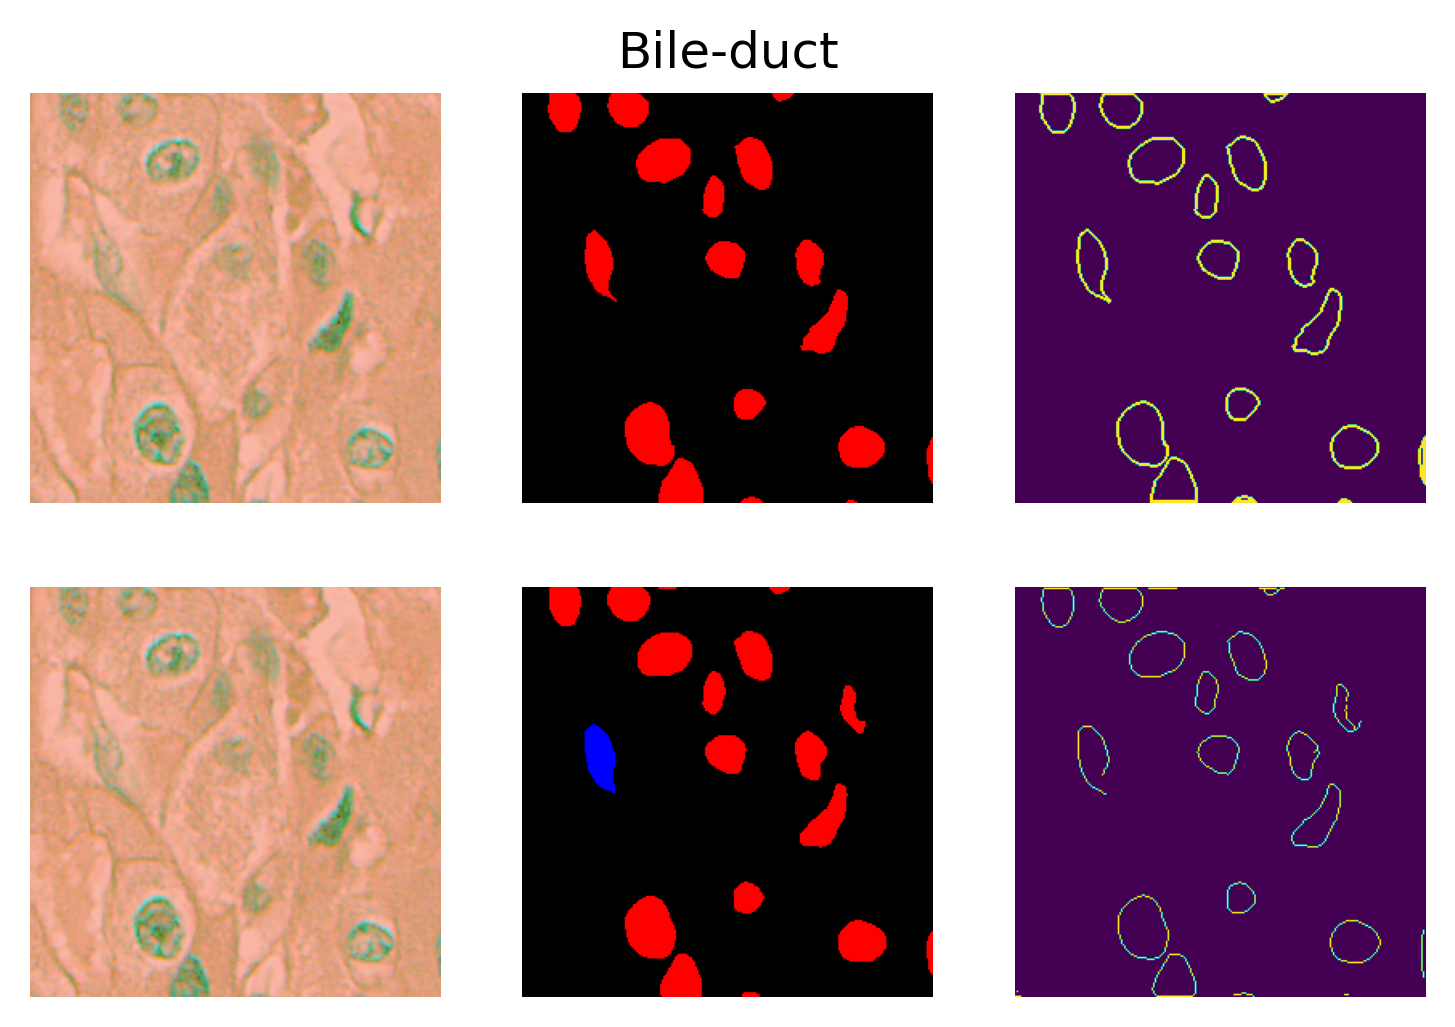

In [9]:
from morphology import (bwmorph_thin, gray2encoded, seprate_instances, water, 
                        remove_small_obj_n_holes, assgin_via_majority, decode_predictions)
from metrics import Class_Wise_IOU, strict_iou
idx = np.random.randint(0, 1589)

thresh = 0.5
img_rgb, sem , inst, h = Tumor_IO(test_imgs_paths[idx], test_sem_masks_paths[idx],
                                    test_inst_masks_paths[idx], im_width, im_height, False)
img = np.concatenate((img_rgb, h), axis=-1)
img = img[np.newaxis, :,:,:]
sem_rgb = tf_gray2rgb(sem.squeeze(), pallet_pannuke)
for n in range(len(tumor_types)):
    if os.path.basename(test_imgs_paths[idx]).find(tumor_types[n]) == -1:
        pass
    else:
        lbl = tumor_types[n]

_, seg_op, inst_op = model.predict(img)
seg_op, inst_op = decode_predictions(seg_op, inst_op, thresh)

seg_op_rgb = tf_gray2rgb(seg_op, pallet_pannuke)

mean_iou, cls_iou, _ = Class_Wise_IOU(seg_op, sem.squeeze(), num_class, class_names, True)

fig, ax = plt.subplots(2, 3)
ax[0, 0].imshow(img[0,:,:,3:])
ax[0, 0].axis('off')
ax[0, 1].imshow(sem_rgb)
ax[0, 1].set_title(lbl)
ax[0, 1].axis('off')
ax[0, 2].imshow(inst[:,:,0])
ax[0, 2].axis('off')

ax[1, 0].imshow(img[0,:,:,3:])
ax[1, 0].axis('off')
ax[1, 1].imshow(seg_op_rgb)
ax[1, 1].axis('off')
ax[1, 2].imshow(inst_op)
ax[1, 2].axis('off')

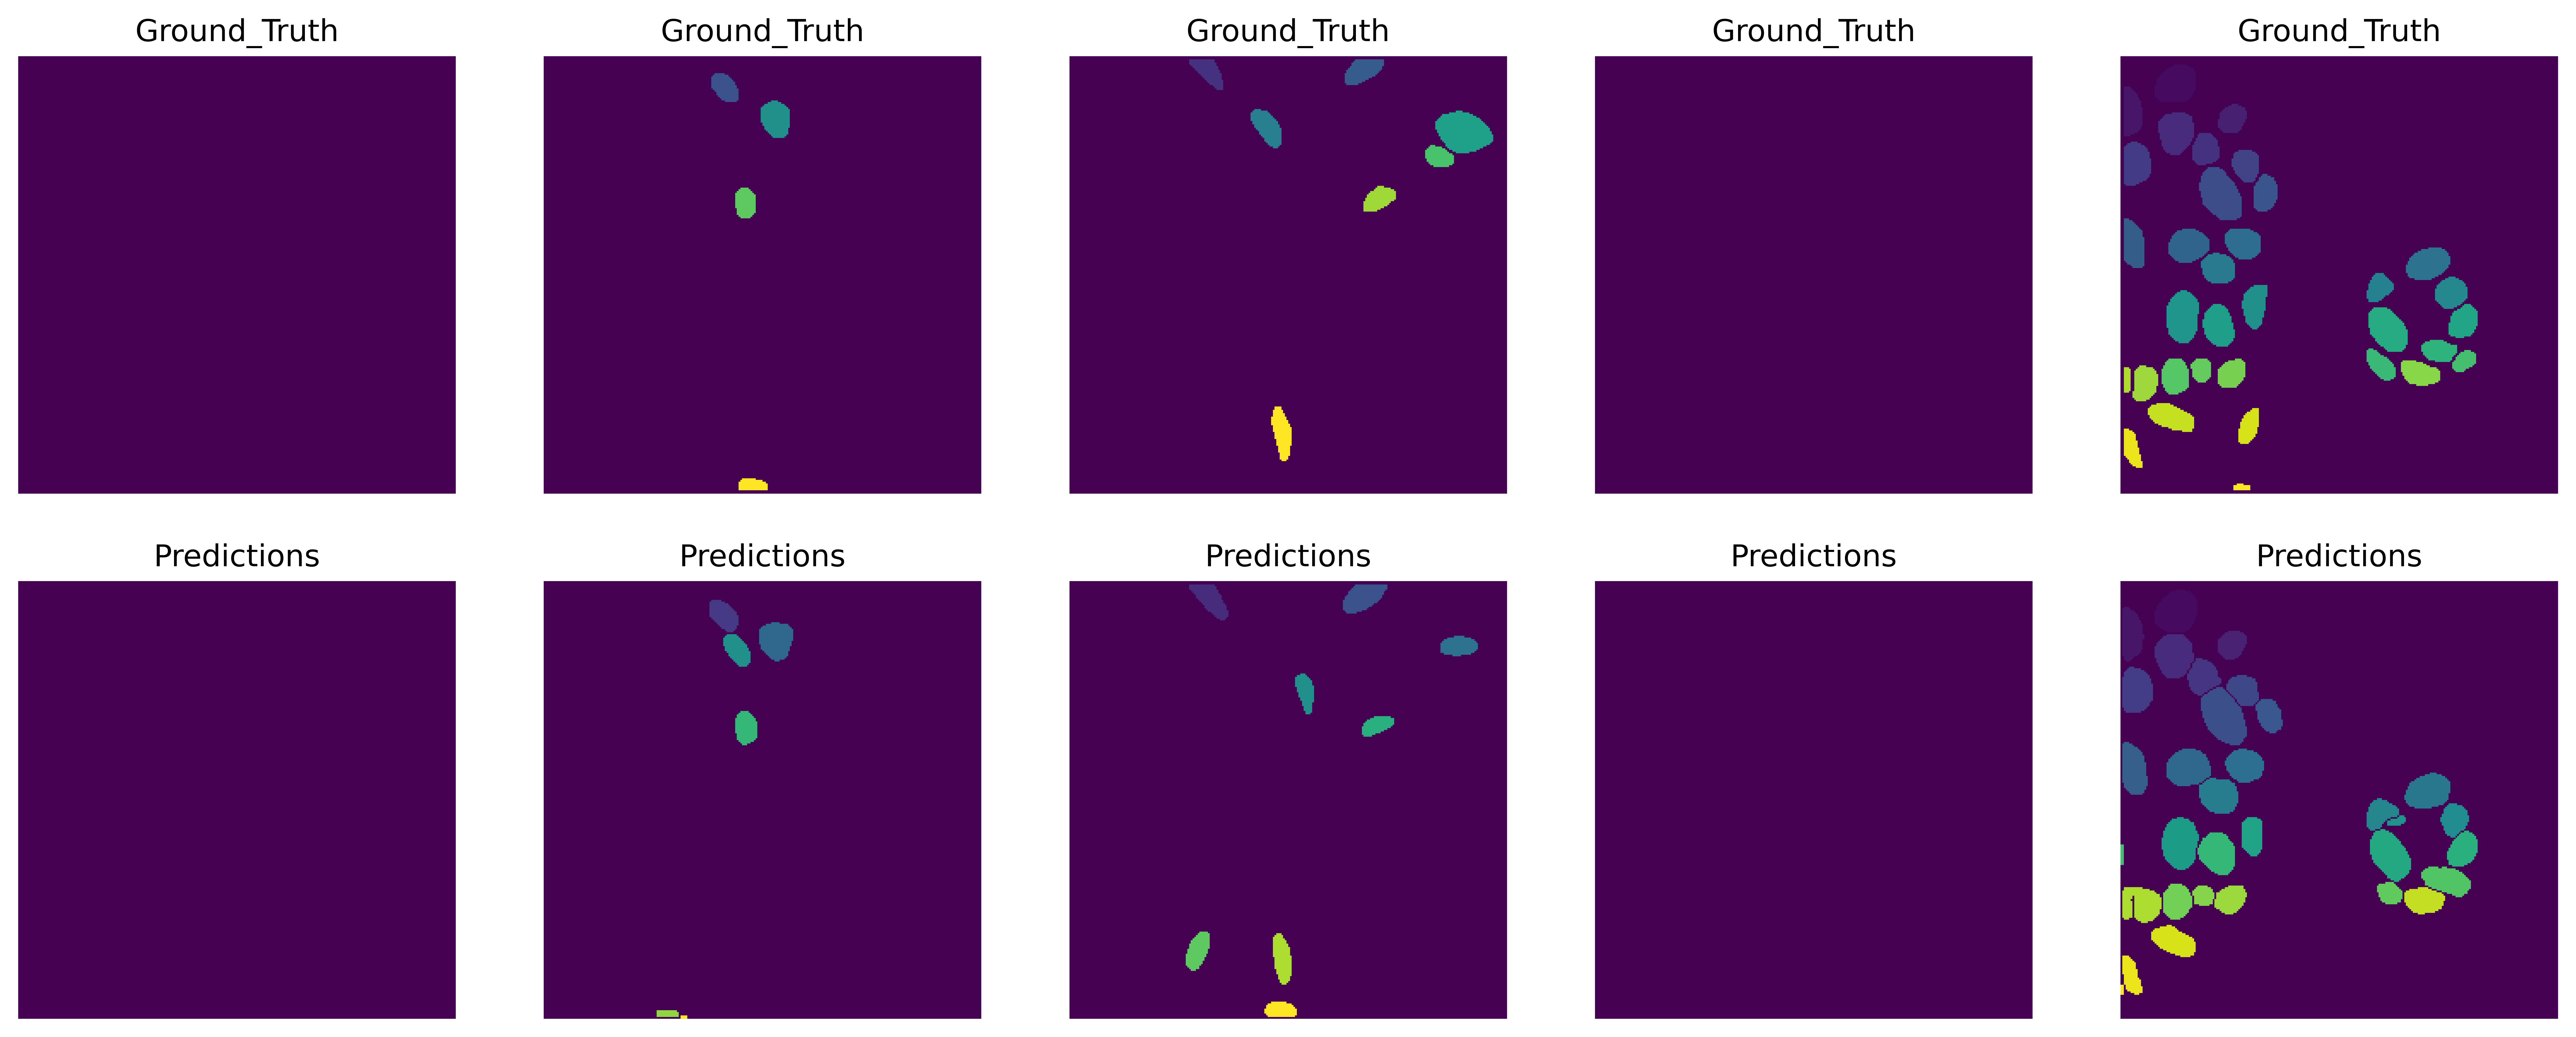

In [23]:
from plotting import plot_instances
pred_sep_inst = seprate_instances(seg_op, inst_op, 6, True, 3)
gt_sep_inst = seprate_instances(sem.squeeze(), inst.squeeze(), 6, True, 3)

f = plot_instances(pred_sep_inst, gt_sep_inst)

(-0.5, 255.5, 255.5, -0.5)

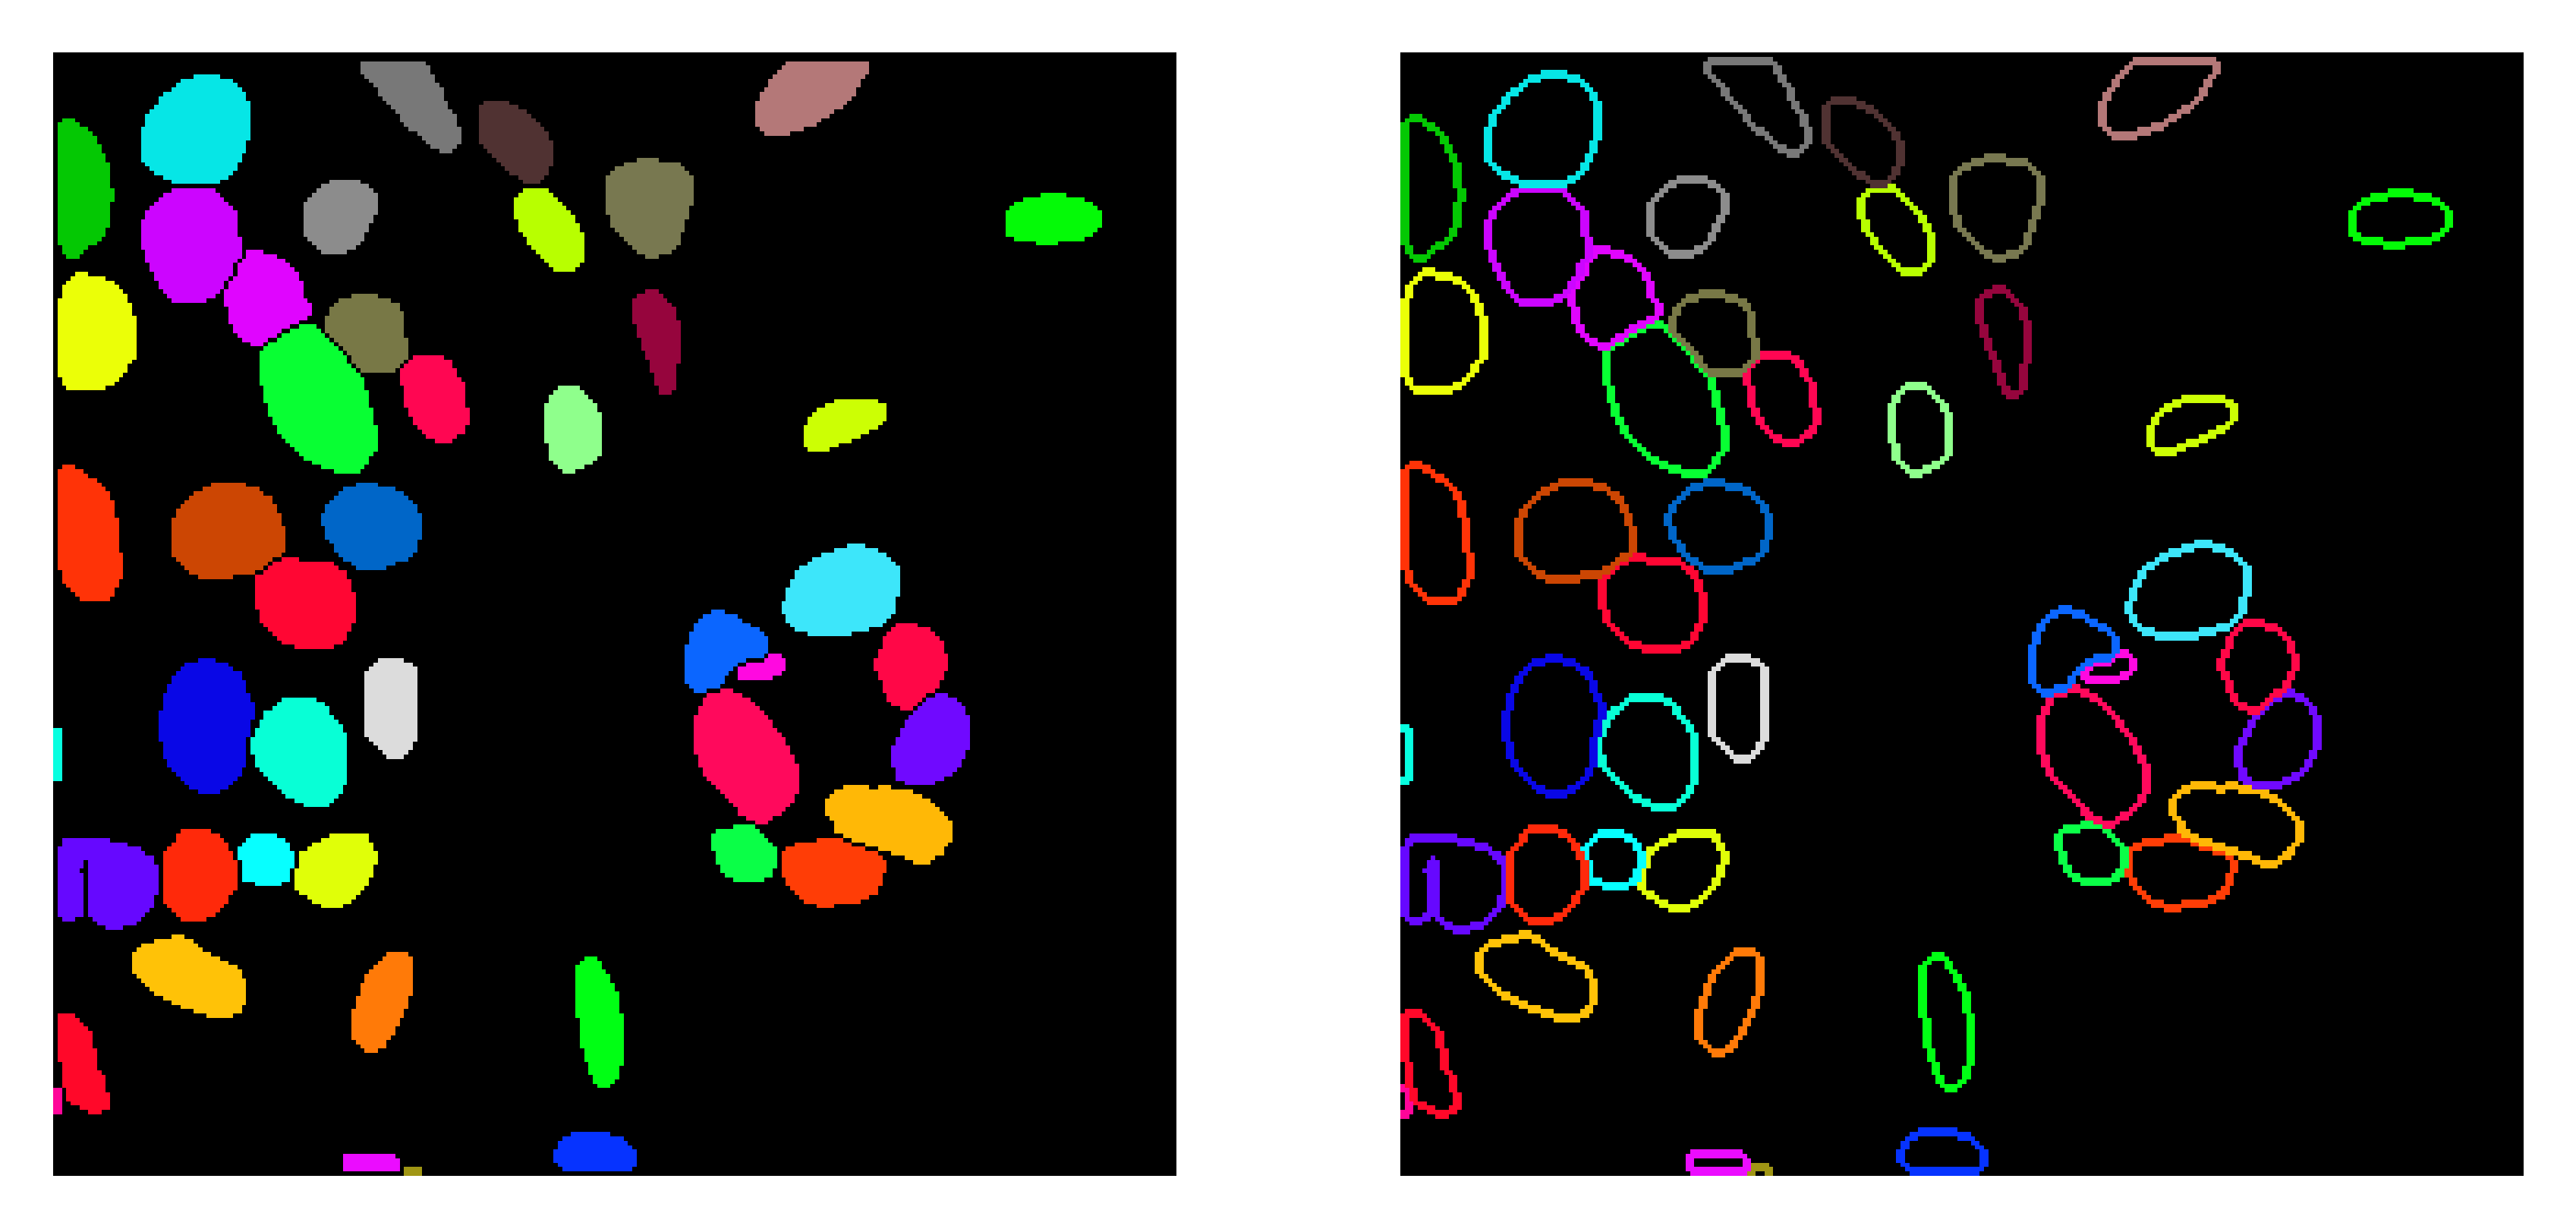

In [24]:
from morphology import get_inst_seg, get_inst_seg_bdr
pred_sep_inst = seprate_instances(seg_op, inst_op, 6, True, 3)
gt_sep_inst = seprate_instances(sem.squeeze(), inst.squeeze(), 6, True, 3)

x = get_inst_seg(pred_sep_inst, img_rgb, blend=False)
y = get_inst_seg_bdr(pred_sep_inst, img_rgb, blend=False)

fig, ax = plt.subplots(1,2)
ax[0].imshow(x)
ax[0].axis('off')
ax[1].imshow(y)
ax[1].axis('off')

In [8]:
from morphology import (bwmorph_thin, gray2encoded, seprate_instances, water, my_argmax,
                        remove_small_obj_n_holes, assgin_via_majority, decode_predictions,
                        plot_confusion_matrix)
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, average_precision_score, roc_curve, auc
from itertools import cycle

n_classes = num_class - 1 # remove BG class
length = len(test_imgs_paths)
thresh = 0.5
# pixel wise raw score/probabilities after activation i.e. [0.01, 0.1, 0.2, ..., 0.78, 0.9]
orig_pred_pr = np.zeros((length, 256, 256, 5)) 
# pixel wise confidence after applying threshold i.e. [0, 0, 0, ..., 1, 1]
orig_pred_thresh = np.zeros((length, 256, 256, 5)) 
# pixel wise confidence of GT i.e. [0, 0, 0, ..., 1, 1]
orig_gt_pr = np.zeros((length, 256, 256, 5))
types = []
names = []
for i in trange(length, desc='Making Arrays for running Eval script'):
    # saving predictions
    img_rgb, sem_gt , inst_gt, h = Tumor_IO(test_imgs_paths[i], test_sem_masks_paths[i], test_inst_masks_paths[i], 512, 512, False)
    img = np.concatenate((img_rgb, h), axis=-1)
    img = img[np.newaxis, :,:,:]
    # get prediction
    _, seg_op, _ = model.predict(img)
    seg_op = softmax_activation(seg_op).squeeze()
    seg_op = seg_op[:,:,1:] # remove the BG channel
    orig_pred_pr[i, ...] = seg_op
    
    seg_op = (seg_op > thresh).astype(np.uint8)
    orig_pred_thresh[i, ...] = seg_op
    # saving GT in array form
    sem_mask = sem_gt.squeeze()
    sem_mask = gray2encoded(sem_mask, num_class)
    sem_mask = sem_mask[:,:,1:] # remove the BG channel
    orig_gt_pr[i, ...] = sem_mask

Making Arrays for running Eval script: 100%|██████████| 1923/1923 [04:39<00:00,  6.88it/s]


In [ ]:
#********************Percision & Recall values for each class************************
gt = orig_gt_pr
preds_val_t = orig_pred_thresh
print("Following values are at the Threshold(@ confidence Score)=", thresh)
for j in trange(n_classes):
    
    ground_truth_labels = gt[:,:,:,j].ravel() 
    score_value = preds_val_t[:,:,:,j].ravel() 
    pre, rec, f1, _ = precision_recall_fscore_support(ground_truth_labels, score_value, average= 'macro')
    print(tabulate([[j+1, pre, rec, f1]], headers=['class', 'Precision', 'Recall', 'F1-Score'], tablefmt='orgtbl')) 


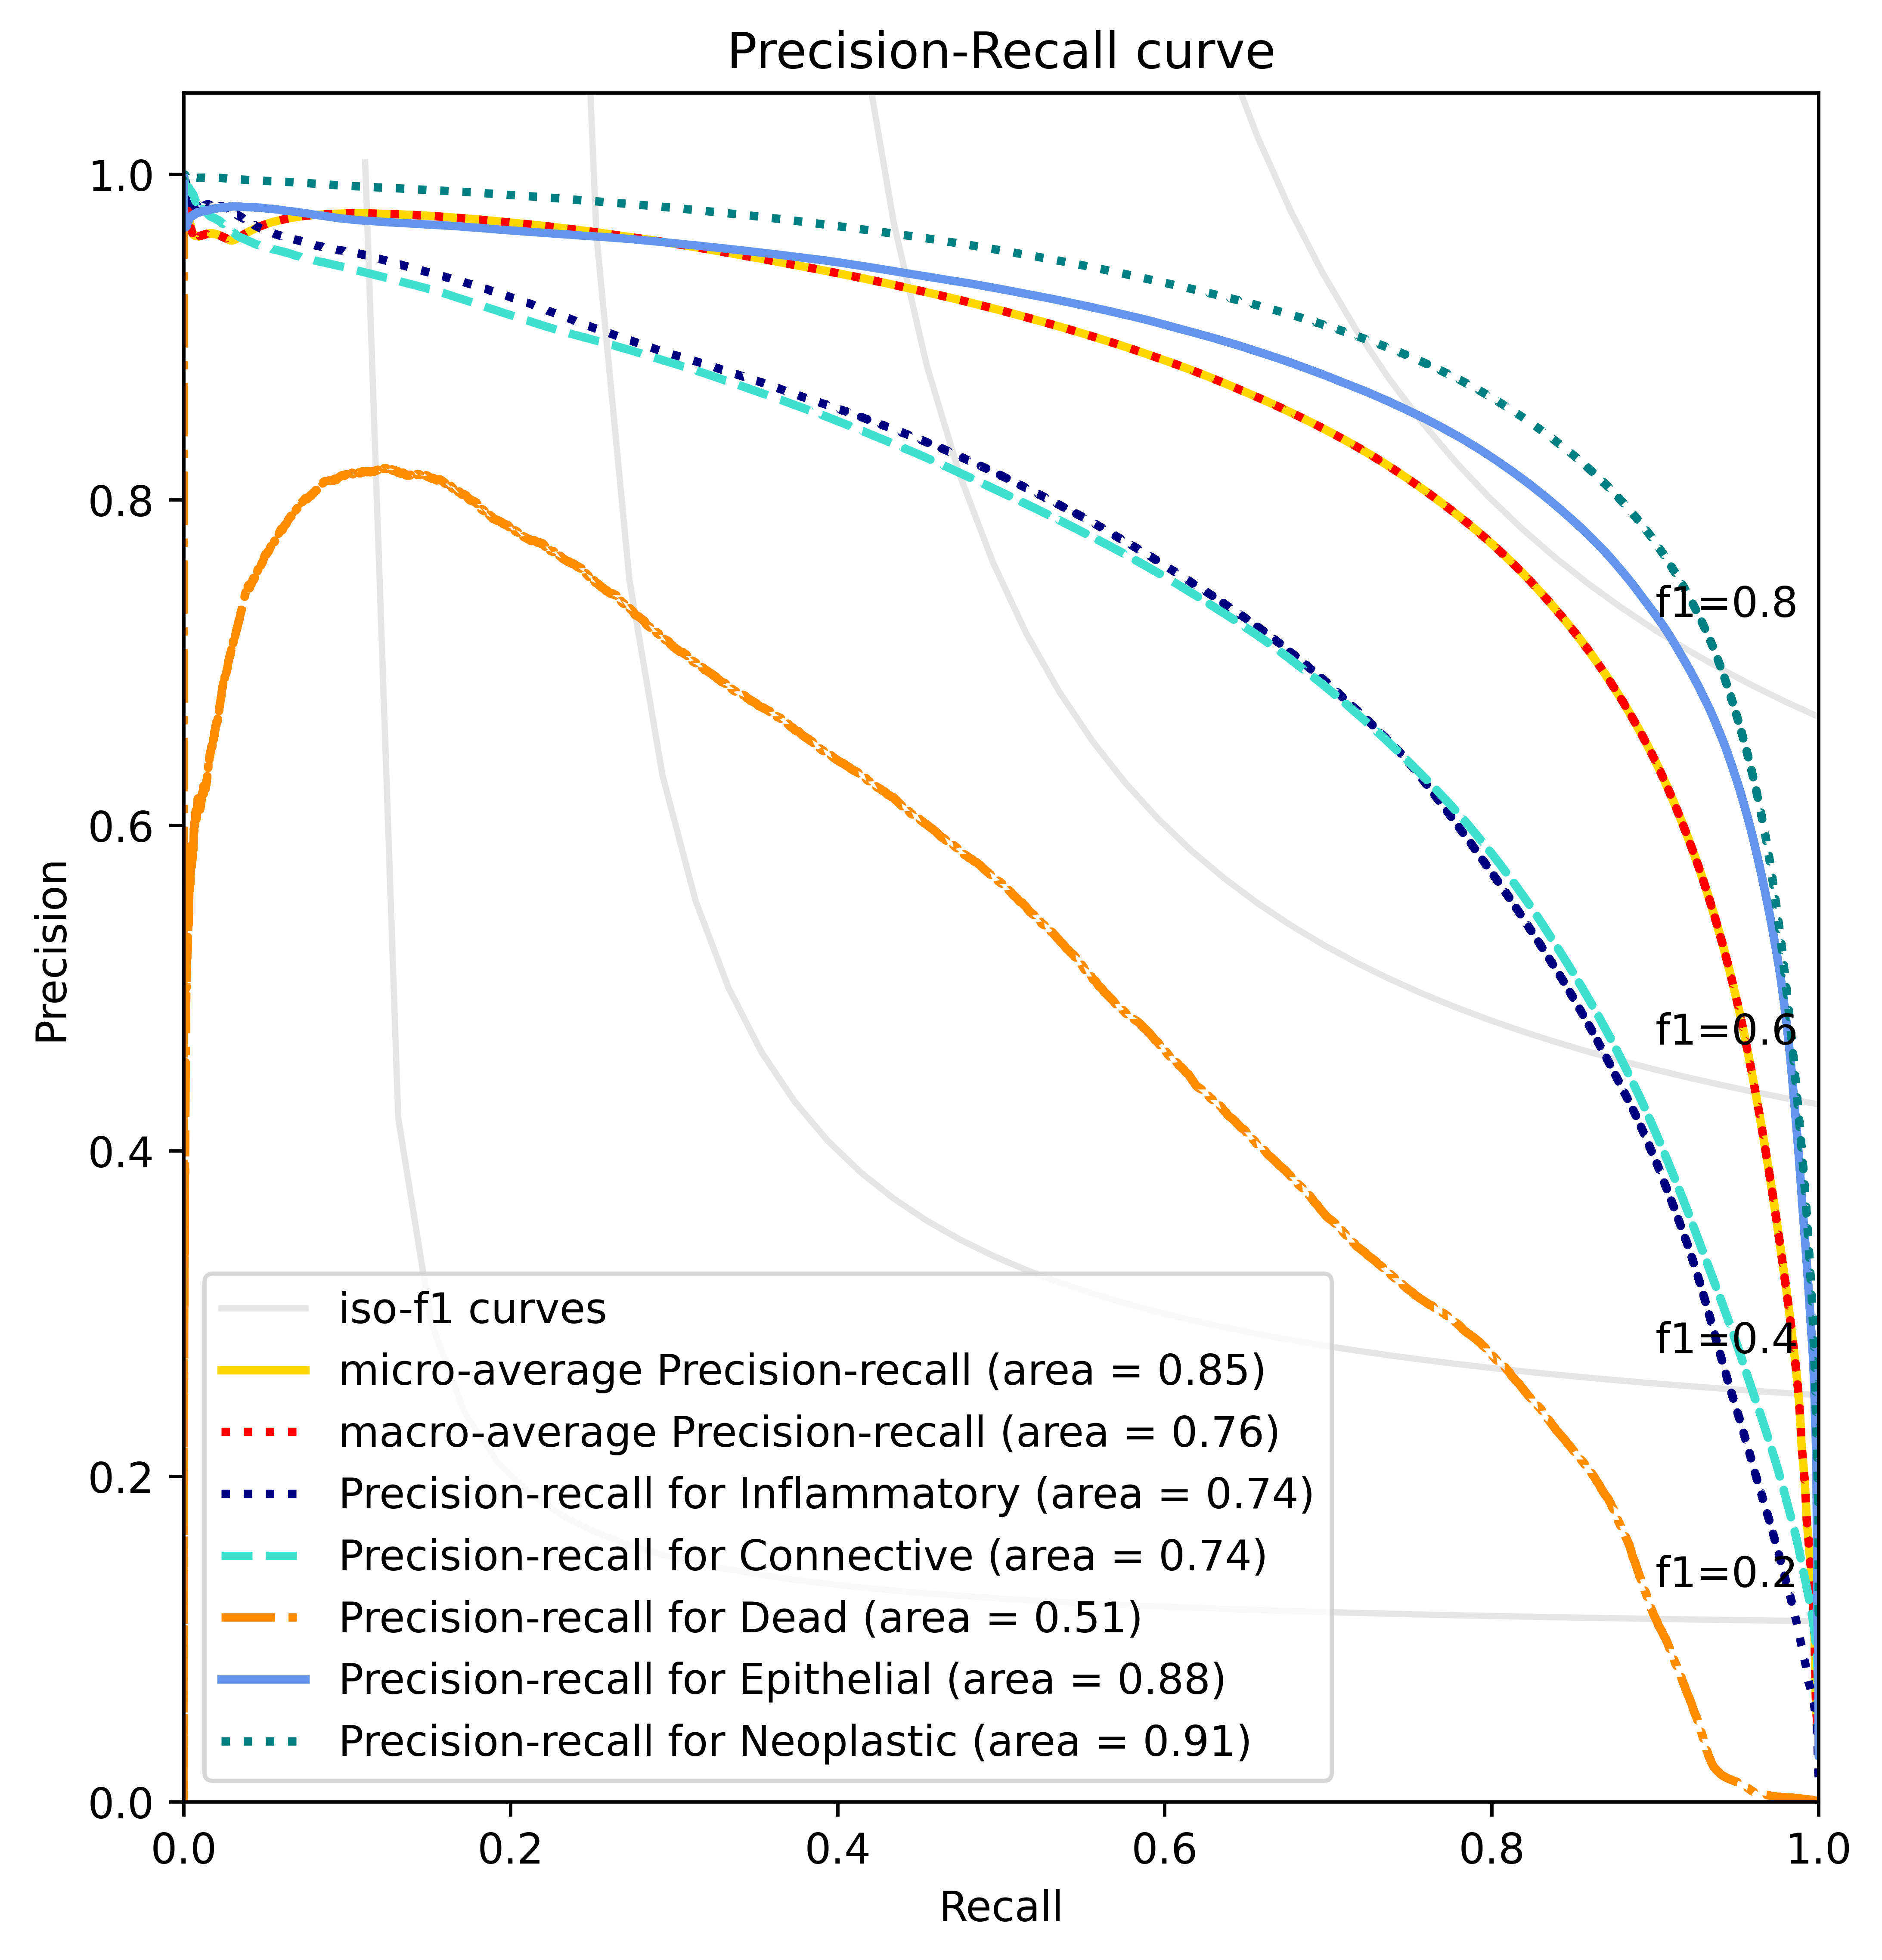

Time taken: 1596.327143907547 seconds


In [23]:
preds_pr = orig_pred_pr.reshape(-1, n_classes)
gt_pr = orig_gt_pr.reshape(-1, n_classes)
s = time.time()
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(gt_pr[:, i], preds_pr[:, i])
    average_precision[i] = average_precision_score(gt_pr[:, i], preds_pr[:, i])
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(gt_pr.ravel(),preds_pr.ravel())
average_precision["micro"] = average_precision_score(gt_pr, preds_pr,average="micro")
average_precision["macro"] = average_precision_score(gt_pr, preds_pr,average="macro")
#print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))

# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'aqua'])
l_style = cycle([':','--', '-.', '-'])
plt.figure(figsize=(7, 9))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')

l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

l, = plt.plot(recall["micro"], precision["micro"], color='red',linestyle=':', lw=2)
lines.append(l)

labels.append('macro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["macro"]))
class_name = cycle(["Inflammatory", "Connective", "Dead", "Epithelial", "Neoplastic"])
for i, name, color, line_style in zip(range(n_classes), class_name, colors, l_style):
    l, = plt.plot(recall[i], precision[i], color=color, linestyle=line_style, lw=2)
    lines.append(l)
    labels.append('Precision-recall for {0} (area = {1:0.2f})'''.format(name, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
#plt.plot([0, 1],[1, 0], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
#plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))
plt.legend(lines, labels,loc="lower left")
plt.show()
print('Time taken: {} seconds'.format(time.time()-s))

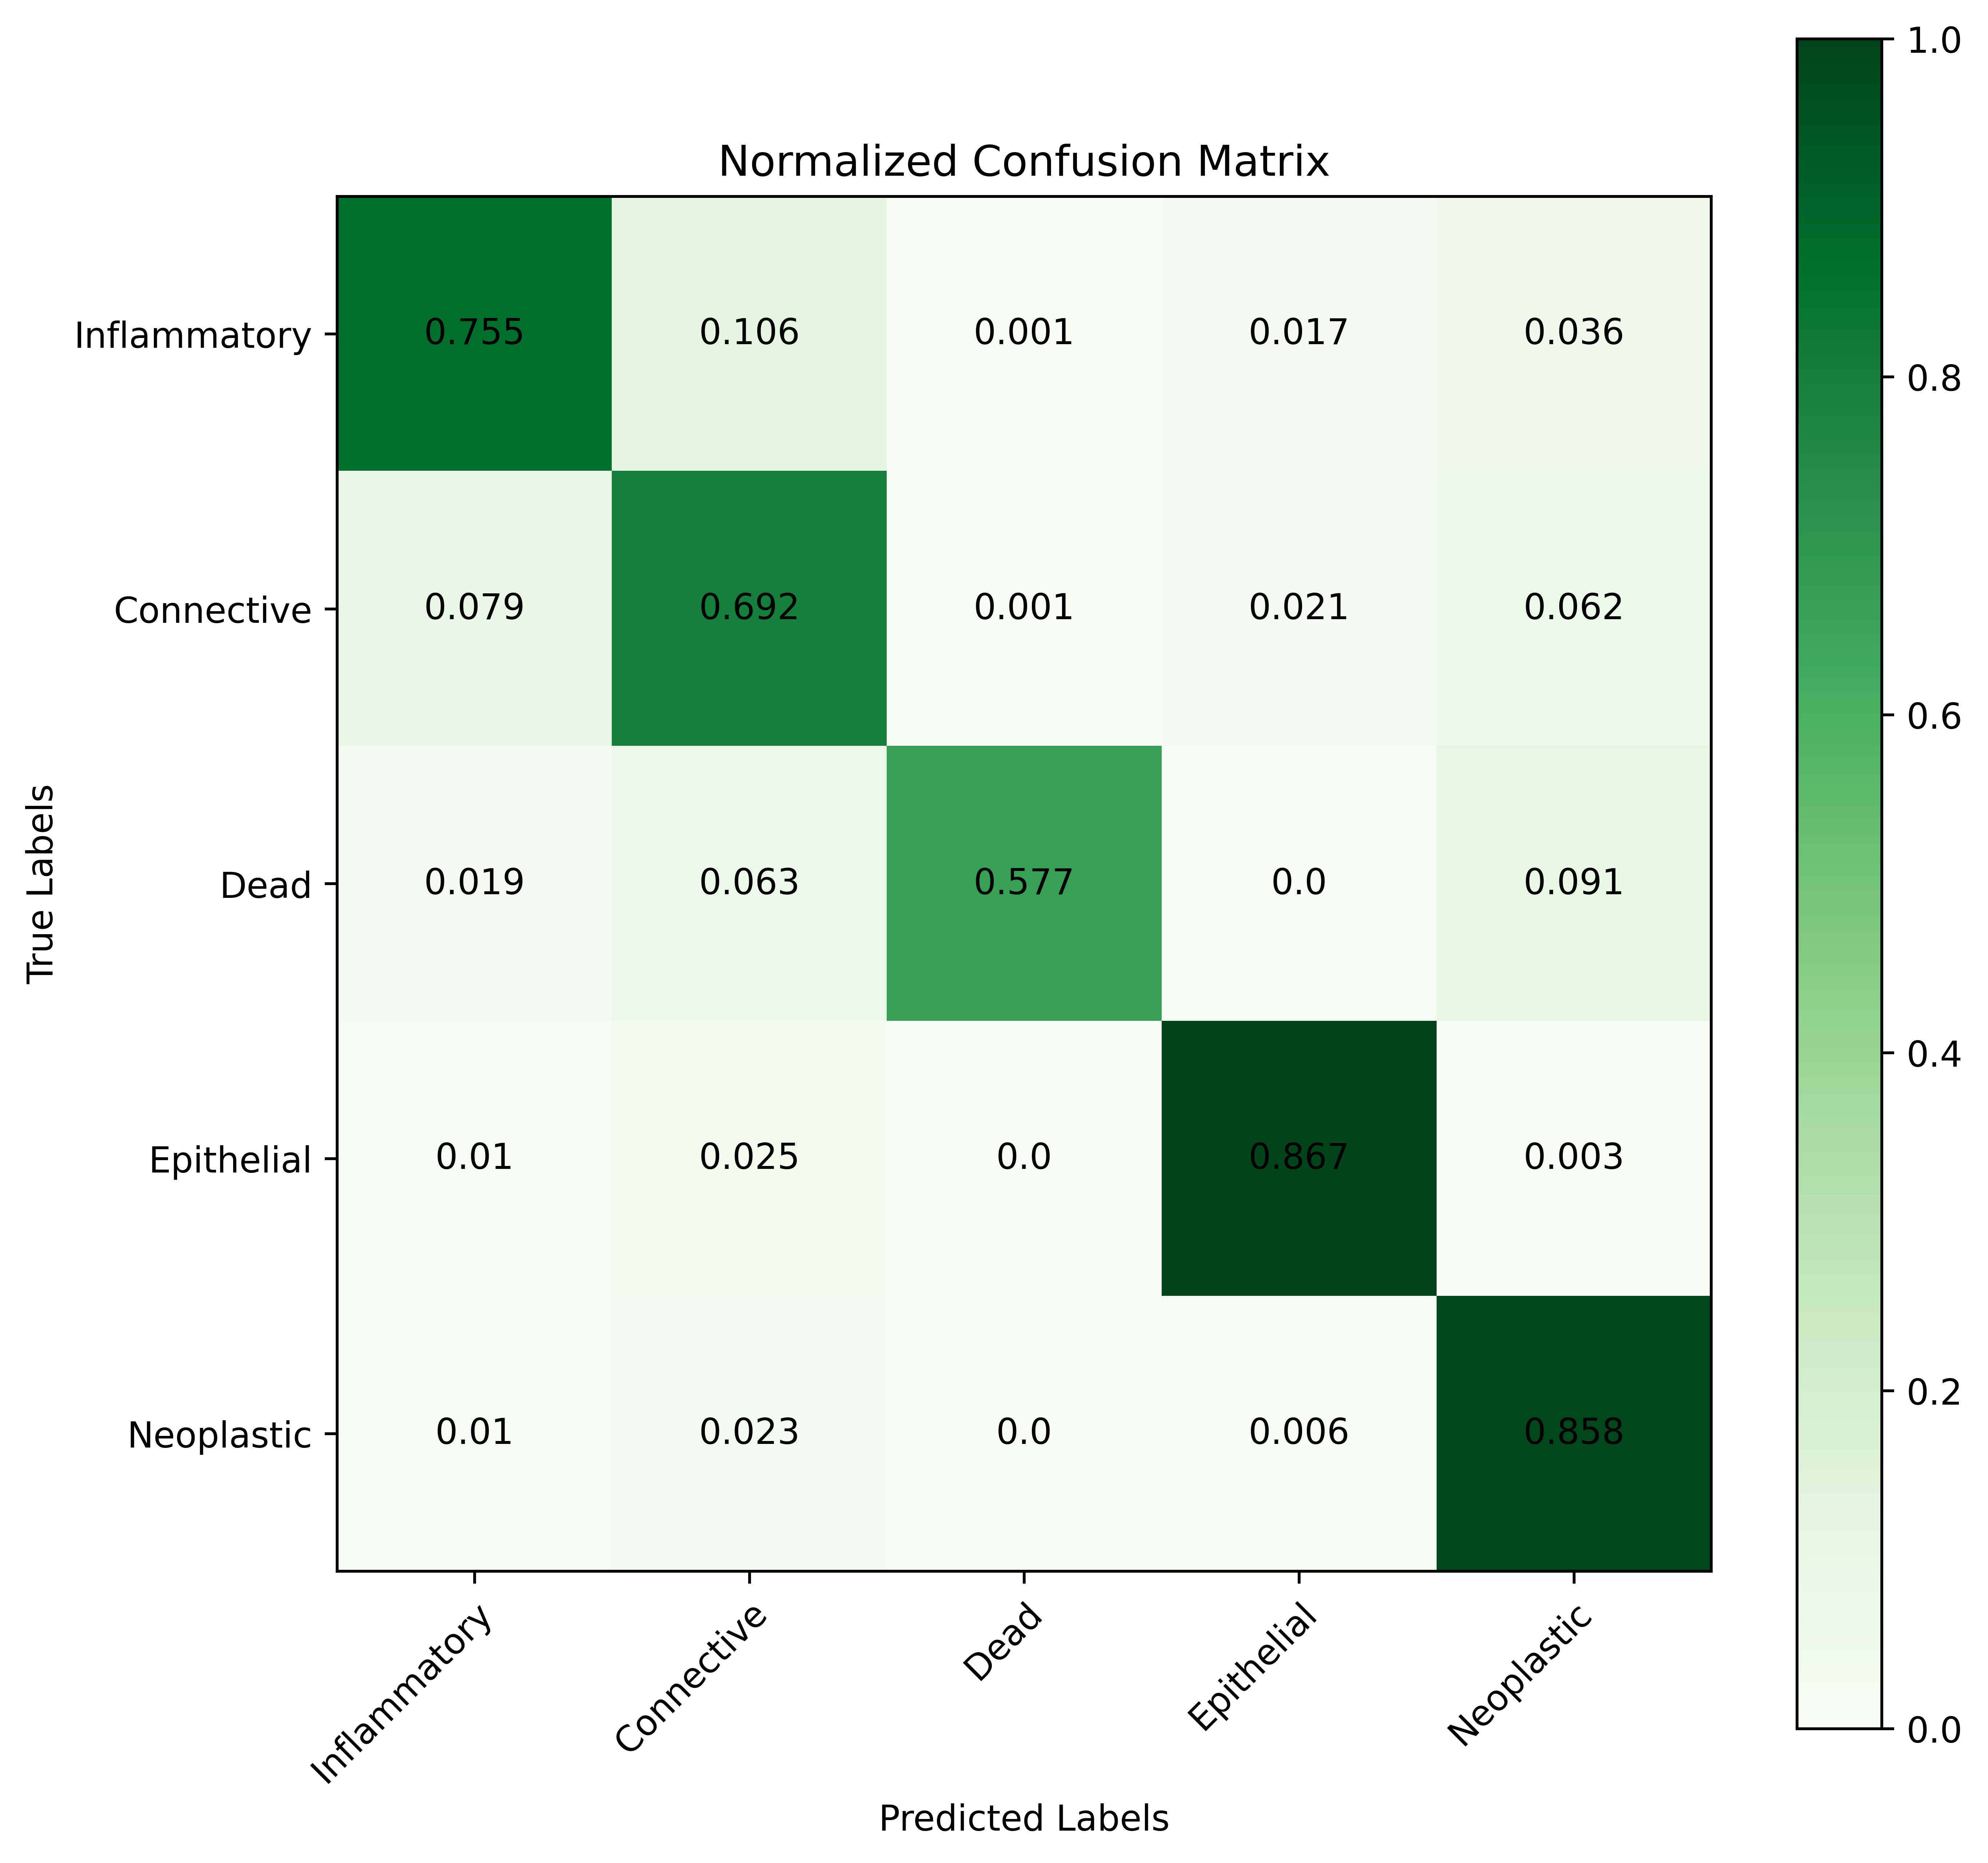

In [32]:
from sklearn.metrics import confusion_matrix

# here we cant directly use argmax
gt_pr = my_argmax(orig_gt_pr).reshape(-1,1)
preds_pr = my_argmax(orig_pred_thresh).reshape(-1,1)


y_true = gt_pr
y_pred = preds_pr
conf_mat = np.round(confusion_matrix(y_true, y_pred, normalize='true'), 3)

classes = ["Inflammatory", "Connective", "Dead", "Epithelial", "Neoplastic"]
fig = plot_confusion_matrix(conf_mat, classes, normalize = False,
                            show_text = True, from_clf = False, my_cmap = 'Greens')
# viridis, seismic, gray, ocean, CMRmap, RdYlBu, rainbow, jet, Blues, Greens, Purples

In [26]:
length = len(test_imgs_paths)
thresh = 0.5
#i = 1000
gt = []
pred = []
for i in trange(length, desc='Getting Classifier Predictions'):
    # saving predictions
    img_rgb, _, _, h = Tumor_IO(test_imgs_paths[i], test_sem_masks_paths[i], test_inst_masks_paths[i], 512, 512, False)
    img = np.concatenate((img_rgb, h), axis=-1)
    img = img[np.newaxis, :,:,:]
    # get prediction
    clf_pred, _, _ = model.predict(img)
    # get GT clf label form file name same as in Data_Gen
    clf_gt = np.zeros(tumor_types.shape)
    for idx in range(len(tumor_types)):
        if os.path.basename(test_imgs_paths[i]).find(tumor_types[idx]) == -1:
            pass
        else:
            clf_gt[idx] = 1
    
    gt.append(np.argmax(clf_gt))
    pred.append(np.argmax(clf_pred))


cm_clf = confusion_matrix(gt, pred)
# viridis, seismic, gray, ocean, CMRmap, RdYlBu, rainbow, jet, Blues, Greens, Purples
fig = plot_confusion_matrix(cm_clf, tumor_types, normalize = True,
                            show_text = False, from_clf = True, my_cmap = 'viridis')